# import

In [99]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import re

from datetime import datetime, timedelta

# Загрузим инструмент для генерации полиномиальных признаков:
from sklearn.preprocessing import PolynomialFeatures

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/european-tourists/tourists.csv
/kaggle/input/european-city-population/population.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv


In [100]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [101]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [102]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
pop = pd.read_csv('/kaggle/input/european-city-population/population.csv')
visitors = pd.read_csv('/kaggle/input/european-tourists/tourists.csv', delimiter = ';')

In [103]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [104]:
df_train.head(10)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963
5,id_1418,Oporto,NaN,1419.0,3.0,NaN,2.0,"[['There are better 3 star hotel bars', 'Amazi...",/Restaurant_Review-g189180-d12503536-Reviews-D...,d12503536
6,id_1720,Milan,"['Italian', 'Pizza']",1722.0,4.0,$,50.0,"[['Excellent simple local eatery.', 'Excellent...",/Restaurant_Review-g187849-d5808504-Reviews-Pi...,d5808504
7,id_825,Bratislava,['Italian'],826.0,3.0,NaN,9.0,"[['Wasting of money', 'excellent cuisine'], ['...",/Restaurant_Review-g274924-d3199765-Reviews-Ri...,d3199765
8,id_2690,Vienna,NaN,2692.0,4.0,NaN,NaN,"[[], []]",/Restaurant_Review-g190454-d12845029-Reviews-G...,d12845029
9,id_4209,Rome,"['Italian', 'Pizza', 'Fast Food']",4210.0,4.0,$,55.0,"[['Clean efficient staff', 'Nice little pizza ...",/Restaurant_Review-g187791-d8020681-Reviews-Qu...,d8020681


In [105]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [106]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [107]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [108]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [109]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [111]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
48100,id_4287,Paris,"['French', 'Wine Bar']",4288.0,$$ - $$$,56.0,"[['If Hemingway was alive...', 'Wonderful for ...",/Restaurant_Review-g187147-d1207588-Reviews-La...,d1207588,1,4.5
48412,id_1082,Geneva,"['French', 'European']",1086.0,$$ - $$$,NaN,"[[], []]",/Restaurant_Review-g188057-d12881093-Reviews-C...,d12881093,1,4.0
45786,id_5414,Milan,"['Japanese', 'Sushi', 'Asian']",5417.0,$$ - $$$,222.0,"[['Not bad but not', 'TERRIBLE!'], ['08/31/201...",/Restaurant_Review-g187849-d2152109-Reviews-Su...,d2152109,1,3.0
17565,id_3321,Prague,"['Lebanese', 'Fast Food', 'Mediterranean']",3328.0,$$ - $$$,10.0,"[['Eat Arabic food in Prague', 'What happened?...",/Restaurant_Review-g274707-d7707903-Reviews-Sa...,d7707903,1,3.5
814,id_814,Brussels,"['Italian', 'Contemporary', 'Wine Bar', 'Medit...",641.0,$$ - $$$,30.0,"[['Amazing', 'Excellent meals and cocktails'],...",/Restaurant_Review-g188644-d7387621-Reviews-Le...,d7387621,0,0.0


In [112]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 0. Functions

In [113]:
# формирует список, разбиением текстовой строки на элементы отделенные запятой и очищает их от кавычек и скобок

def clear_text_list (text_list):
    clear_list = [element.strip("'[]") for element in text_list.split("', '")]
    return clear_list

In [114]:
# возвращает среднюю длину элемента для списка строк
def len_mean (strlist):
    s=0
    for el in strlist:
        s+= len(el)
    return s/len(strlist)

In [115]:
# Функция, сокращающая разнообразие кухонь, заменяет название малочисленной кухни на название кухни к которой может быть отнесена
def cuisine_correct(cuisine_list):
    old_cuisine = ['Xinjiang', 'Yunnan', 'Salvadoran', 'Chilean', 'Ecuadorean', 'Central Asian', 'Albanian', 'Romanian',
                   'Minority Chinese', 'Danish', 'Norwegian', 'Swedish', 'Peruvian', 'Polish', 'Russian', 'Ukrainian', 'Burmese',
                   'Latvian', 'New Zealand', 'Fujian', 'Polynesian', 'Filipino', 'Singaporean', 'Sri Lankan', 'Australian',
                   'Taiwanese', 'Slovenian', 'Indonesian', 'Venezuelan', 'Malaysian', 'Croatian', 'Ethiopian', 'Tunisian', 'Afghani',
                   'Persian', 'Georgian', 'Armenian', 'Azerbaijani', 'Egyptian', 'Colombian', 'Cuban', 'Brazilian', 'Arabic',
                   'Moroccan', 'Cambodian', 'Nepali', 'Jamaican', 'Pakistani',  'Bangladeshi', 'Lebanese', 'Argentinean', 'Dutch',
                   'Hungarian', 'Czech', 'Vietnamese', 'Canadian', 'Steakhouse', 'Barbecue', 'Grill', 'Belgian', 'Swiss', 'Uzbek',
                   'Welsh', 'Scottish', 'Mongolian', 'Hawaiian', 'Cajun & Creole', 'Tibetan', 'Irish', 'Austrian', 'German', 'Korean',
                   'Central American', 'Thai', 'Balti', 'Native American', 'Israeli', 'Turkish', 'Greek', 'Latin', 'Sushi', 'Chinese',
                   'Diner']
    new_cuisine = ['Asian', 'Asian', 'South American', 'South American', 'South American', 'Asian', 'Eastern European',
                   'Eastern European', 'Asian', 'Scandinavian', 'Scandinavian', 'Scandinavian', 'South American', 'Eastern European',
                   'Eastern European', 'Eastern European', 'Asian', 'North European', 'Oceania', 'Oceania', 'Oceania', 'Asian', 'Asian',
                   'Asian', 'Oceania', 'Asian', 'Eastern European', 'Asian', 'South American', 'Asian', 'Eastern European', 'African',
                   'African', 'Middle Eastern', 'Middle Eastern', 'Caucasian', 'Caucasian', 'Caucasian', 'African', 'South American',
                   'Caribbean', 'South American', 'Middle Eastern', 'African', 'Asian', 'Indian', 'Caribbean', 'Indian', 'Indian',
                   'Middle Eastern', 'South American', 'Scandinavian', 'Eastern European', 'Eastern European', 'Asian', 'American',
                   'Meat', 'Meat', 'Meat', 'Central European', 'Central European', 'Asian', 'North European', 'North European', 'Asian',
                   'Caribbean', 'Caribbean', 'Asian', 'North European', 'Central European', 'Central European', 'Asian', 'Mexican',
                   'Asian', 'North European', 'American', 'Middle Eastern', 'Mediterranean', 'Mediterranean', 'Mexican', 'Japanese',
                   'Asian', 'Cafe']
    for i in range(len(old_cuisine)):
        if old_cuisine[i] in cuisine_list:
            cuisine_list = [
                *map({old_cuisine[i]: new_cuisine[i]}.get, cuisine_list, cuisine_list)]
    return(cuisine_list)

In [116]:
# Функция поиска кухни в списке кухонь ресторана, служит для заполнения dummy-переменных
def find_cuisin(restaurant, cuisin):
    if cuisin in restaurant:
        return 1
    return 0

In [117]:
# функции для разделения ресторанов на группы по типу кухни
local = ['British', 'Cafe', 'Central European', 'Contemporary', 'Delicatessen', 'Eastern European',
         'European', 'French', 'Fusion', 'Gastropub', 'International', 'Italian', 'Meat', 'Mediterranean', 'North European',
         'Pizza', 'Portuguese', 'Scandinavian',  'Soups', 'Spanish']
exotic = ['African', 'American', 'Asian', 'Caribbean', 'Caucasian', 'Indian',  'Japanese', 
          'Mexican', 'Middle Eastern',  'Oceania',  'Seafood',  'South American', 'Southwestern']

healthy = ['Gluten Free Options', 'Halal', 'Healthy', 'Kosher','Vegan Options', 'Vegetarian Friendly']

fastfood = ['Fast Food', 'Street Food']

drinks = ['Bar', 'Brew Pub','Pub', 'Wine Bar']

def local_cuisine(cuisines):
    for cuisine in cuisines:
        if cuisine in local:
            return(1)
            break
        return(0)

def exotic_cuisine(cuisines):
    for cuisine in cuisines:
        if cuisine in exotic:
            return(1)
            break
        return(0)

def healthy_cuisine (cuisines):
    for cuisine in cuisines:
        if cuisine in healthy:
            return(1)
            break
        return(0)
    
def fastfood_cuisine (cuisines):
    for cuisine in cuisines:
        if cuisine in fastfood:
            return(1)
            break
        return(0)

def drinks_cuisine (cuisines):
    for cuisine in cuisines:
        if cuisine in drinks:
            return(1)
            break
        return(0)

In [118]:
# Функция определяющая по 20% лучших и худших рэнкингов внутри города // в итоговой обработке func_proc не используется
def rank_pctl (city):
    return(np.percentile(data[data['City']==city].Ranking, [20, 80]))

In [119]:
# Функция округления рейтинга с точностью 0,5

def rating_round (rating):
    rating = round(rating / 0.5 + 0.0001) * 0.5
    return (rating)

## 1. Обработка NAN 

In [120]:
# Зафиксируем столбец с признаком пропуска в количестве отзывов
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [121]:
# Зафиксируем столбец с признаком пропуска в стиле кухни - идея не оправдалась
# data['Cuisine_Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')

In [122]:
# Уберем пропуски в признаке кухня, поскольку все города находятся в Европе, кухню по умолчанию будем считать европейской
# Была идея заполнить пропуск самой популярной кухней в городе, но не успел.
data['Cuisine Style'] = data['Cuisine Style'].fillna('European')

In [123]:
# Пропуски в обзорах заполним пустой строкой
data['Reviews'] = data['Reviews'].fillna('')

### 2. Обработка признаков

### Кухни

In [124]:
# Конвертируем текстовый признак Кухня в список кухонь у каждого ресторана
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: clear_text_list(x))

In [125]:
# Создадим новый призак - количество разновидностей кухонь в ресторане
data['cuisine_number'] = data['Cuisine Style'].apply(lambda x: len(x))

In [126]:
# Сгруппируем кухни чтобы уменьшить количество их разновидностей
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: cuisine_correct(x))

In [127]:
# Создадим новые признаки - Местная кухня, Экзотическая кухня, Здоровая кухня, Фаст-фуд, Drinks

data['local'] = data['Cuisine Style'].apply(local_cuisine)
data['exotic'] = data['Cuisine Style'].apply(exotic_cuisine)
data['healthy'] = data['Cuisine Style'].apply(healthy_cuisine)
data['fastfood'] = data['Cuisine Style'].apply(fastfood_cuisine)
data['drinks'] = data['Cuisine Style'].apply(drinks_cuisine)


### Даты отзывов

In [128]:
# При помощи регулярных выражений выберем из столбца с последними отзывами даты. 
# Получим для каждого ресторана список с датами в текстовом виде
data['review_dates'] = data['Reviews'].apply(lambda x: re.findall(r'\d\d\/\d\d\/\d{4}',x))

In [129]:
# Создадим два столбца с датами последних отзывов и конвертируем их в формат datetime
# Если даты нет - поставим None, если дата только одна - признаки одинаковы
data['review_date1'] = data['review_dates'].apply(lambda x: None if len(x)==0
                                                  else x[0])

data['review_date2'] = data['review_dates'].apply(lambda x: None if len(x)==0
                                                  else x[0] if len(x)==1
                                                  else x[1])

data['review_date1'] = pd.to_datetime(data['review_date1'])
data['review_date2'] = pd.to_datetime(data['review_date2'])

In [130]:
# Заполним пропуски из предположения, что позиция ресторана положительно зависит от даты последнего отзыва, и отсутствие отзыва - это плохо.
data['review_date1'].fillna(datetime(2000,1,1,), inplace=True)
data['review_date2'].fillna(datetime(1990,1,1,), inplace=True)

In [131]:
# Создадим новый признак - timedelta между датами отзывов
data['review_period'] = (data['review_date1'] - data['review_date2'])
data['review_period'] = data['review_period'].apply(lambda x: x.days)

In [132]:
# Создадим новый признак - количество дней, прошедших с последнего отзыва
data['review_date_last'] = data[['review_date1','review_date2']].max(axis=1)
data['days_from_last_review'] = datetime.today() - data['review_date_last']
data['days_from_last_review'] = data['days_from_last_review'].apply(lambda x: x.days)

### Price Range

In [133]:
# Создадим новый ординальный признак - ценовой уровень
data['price_range'] = data['Price Range'].apply(lambda x: None if pd.isnull(x)
                                                else 1 if x == '$'
                                                else 2 if x == '$$ - $$$'
                                                else 3 if x == '$$$$'
                                                else None)

# Пропуски заполним наиболее часто встречающимся значением '$$ - $$$'
data['price_range'].fillna(data['price_range'].mode()[0],inplace=True)

### ID_TA

In [134]:
# Создадим новый признак - предположим, что ID в Tripadvisor генерировался по мере появления ресторана в базе, и это может указывать на "возраст" ресторана 
# и быть ординальным признаком
data['id_ta'] = data['ID_TA'].apply(lambda x: int(x.strip('d')))

### Last Reviews & Number of Reviews

In [135]:
# Займемся длинной отзывов

# 1. Отделим текст от дат
data['review_text'] = data['Reviews'].apply(lambda x: re.split(r'\d\d\/\d\d\/\d{4}',x, maxsplit=1))
data['review_text'] = data['review_text'].apply(lambda x: x[0])

# 2. Уберем лишние символы по краям
data['review_text'] = data['review_text'].apply(lambda x: x.strip("'[], "))

# 3. Создадим список из отзывов
data['review_text'] = data['review_text'].apply(lambda x: clear_text_list(x))

# 4. Создадим новый признак - средняя длина последних отзывов из датасета
data['review_text_len'] = data['review_text'].apply(lambda x: len_mean(x))

In [136]:
# Заполним нулями пропуски в количестве отзывов для тех ресторанов, у которых нет отзывов
data.loc[data.review_text_len == 0, 'Number of Reviews'] = data.loc[data.review_text_len == 0, 'Number of Reviews'].fillna(0)

In [137]:
# Создадим колонку со средним по городу количеством отзывов
avg_rev = pd.DataFrame(data.groupby(by='City').mean()['Number of Reviews']).reset_index()
avg_rev.columns = ['City', 'avg_rev']
data = data.merge(avg_rev, on = 'City', how='left')

In [138]:
# И заполним оставшиеся пропуски в количестве отзывов средним по городу
data['Number of Reviews'].fillna(data['avg_rev'], inplace=True)

Вообще большое количество пропусков в этом признаке - прямое указание на применение парсинга сайта, но не в рамках этого соревнования.

In [139]:
# Создадим признак, насколько количество отзывов отстоит от среднего по городу - по результатам тестирования признак ухдшает МАЕ
data['review_from_avg'] = abs(data['Number of Reviews'] - data['avg_rev'])

### Внешние данные

In [140]:
# Скорректируем название города в исходном датасете
data.loc[data.City == 'Oporto', 'City'] = "Porto"

# Загрузим и присоединим новый числовой признак - данные о населении городов
pop.drop('country', axis=1, inplace=True)
pop.loc[pop.name == "Geneve", 'name'] = "Geneva"
pop.loc[500] = {'name': 'Luxembourg', 'pop': 570000}
pop.columns = ['City', 'population']

data = data.merge(pop, on='City', how='left')

# Создадим новый признак - город столица или нет
A = {'City': ['Paris', 'Stockholm', 'London', 'Berlin', 'Munich', 'Porto', 'Milan', 'Bratislava', 'Vienna', 'Rome', 'Barcelona', 'Madrid', 'Dublin', 'Brussels', 'Zurich', 'Warsaw', 'Budapest', 'Copenhagen', 'Amsterdam', 'Lyon',
              'Hamburg', 'Lisbon', 'Prague', 'Oslo', 'Helsinki', 'Edinburgh', 'Geneva', 'Ljubljana', 'Athens', 'Luxembourg', 'Krakow'], 'capital': [1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0]}
capitals = pd.DataFrame(A)
data = data.merge(capitals, on='City', how='left')

In [141]:
# Добавим признак из внешних источников - посещаемость иностранными туристами
# https://go.euromonitor.com/white-paper-travel-2019-100-cities.html
# https://en.wikipedia.org/wiki/List_of_cities_by_international_visitors

visitors.columns = ['rank', 'City', 'country', '2017', '2018', '2019']
visitors['City']=visitors['City'].apply(lambda x: x.strip(' '))

visitors.loc[100] = {'rank':100, 'City': 'Zurich', 'country':'Switzerland', '2017':0, '2018':0, '2019': 2240}
visitors.loc[101] = {'rank':101, 'City': 'Hamburg', 'country':'Germany', '2017':0, '2018':0, '2019': 1450}
visitors.loc[102] = {'rank':102, 'City': 'Bratislava', 'country':'Czech', '2017':0, '2018':0, '2019': None}
visitors.loc[103] = {'rank':103, 'City': 'Lyon', 'country':'France', '2017':0, '2018':0, '2019': None}
visitors.loc[104] = {'rank':104, 'City': 'Oslo', 'country':'Norway', '2017':0, '2018':0, '2019': None}
visitors.loc[105] = {'rank':105, 'City': 'Helsinki', 'country':'Finland', '2017':0, '2018':0, '2019': None}
visitors.loc[106] = {'rank':106, 'City': 'Edinburgh', 'country':'UK', '2017':0, '2018':0, '2019': 1660}
visitors.loc[107] = {'rank':107, 'City': 'Geneva', 'country':'UK', '2017':0, '2018':0, '2019': 1150}
visitors.loc[108] = {'rank':108, 'City': 'Ljubljana', 'country':'UK', '2017':0, '2018':0, '2019': None}
visitors.loc[109] = {'rank':109, 'City': 'Luxembourg', 'country':'UK', '2017':0, '2018':0, '2019': None}

visitors['2019'] = visitors['2019'].apply(lambda x: None if x == None
                                          else float(x))
# Пропуски заполним минимальным значением
visitors['2019'].fillna(visitors['2019'].min(), inplace=True)

data = data.merge(visitors[['City', '2019']], on='City', how='left')

In [142]:
# Добавим признак количество туристов на 1000 жителей
data['tourist_ratio'] = data['2019'] /data['population']*1000           

In [143]:
# Добавим признаки - количество ресторанов в городе и количество ресторанов на 1000 человек населения
total_rest = pd.DataFrame(data.groupby(by='City').count()['Ranking']).reset_index()
total_rest.columns = ['City', 'total_rest']
data = data.merge(total_rest, on='City', how='left')

data['rest_pop_ratio'] = data['total_rest'] / data['population'] * 1000

In [144]:
# Добавим признак - соотношение Ranking к количеству ресторанов к городе
data['rank_total'] = data['Ranking'] / data['total_rest']

In [145]:
# Добавим признак - количество отзывов на тысячу туристов - по результатам тестирования признак ухдшает МАЕ
data['reviews_by_visitors'] = data['Number of Reviews'] / data['2019'] * 1000

In [146]:
# Добавим признак - количество отзывов на тысячу жителей - по результатам тестирования признак ухдшает МАЕ 
data['reviews_by_pop'] = data['Number of Reviews'] / data['population'] * 1000

In [147]:
# Добавим признак - количество отзывов на тысячу ресторанов в городе
data['reviews_by_rest'] = data['Number of Reviews'] / data['total_rest'] * 1000

In [148]:
# Добавим признак - отнормированный Рэнкинг и его квадрат
rank_stat_DF = pd.DataFrame(columns = ['City', 'rank_mean', 'rank_STD' ])
for city in data['City'].unique():
    rank_mean = data['Ranking'][data['City']==city].mean()
    rank_STD = np.std(data[data['City']==city]['Ranking'])
    rank_stat_DF = rank_stat_DF.append({'City':city, 'rank_mean': rank_mean, 'rank_STD': rank_STD},
                                       ignore_index=True)
    
data = data.merge(rank_stat_DF, on = 'City', how='left')

data['rank_norm'] = (data['Ranking']- data['rank_mean']) / data['rank_STD']

data['rank_norm_sq'] = data['rank_norm'] ** 2

data.drop(['rank_mean', 'rank_STD'], axis=1, inplace=True)

In [149]:
# Добавим признак - отнормированный по min_max Рэнкинг - по результатам тестирования уберем
rank_minmax_DF = pd.DataFrame(columns = ['City', 'rank_min', 'rank_max' ])
for city in data['City'].unique():
    rank_min = data['Ranking'][data['City']==city].min()
    rank_max = data['Ranking'][data['City']==city].max()
    rank_minmax_DF = rank_minmax_DF.append({'City':city, 'rank_min': rank_mean, 'rank_max': rank_max},
                                       ignore_index=True)
    
data = data.merge(rank_minmax_DF, on = 'City', how='left')

data['rank_norm_mm'] = (data['Ranking']- data['rank_min']) / (data['rank_max']-data['rank_min'])

data.drop(['rank_min', 'rank_max'], axis=1, inplace=True)

In [150]:
# Добавим признак - количество отзывов на квадрат нормированного рэнкинга
data['review_by_rank'] = data['Number of Reviews'] / data['rank_norm_sq']

In [151]:
# Добавим признак - средний рэнкинг ресторанов в городе
mid_rank = pd.DataFrame(data.groupby(by='City').mean()['Ranking']).reset_index()
mid_rank.columns = ['City', 'mid_rank']

data = data.merge(mid_rank, on='City', how='left')

In [152]:
# Добавим признак - расстояние до среднего по городу рейтинга
data['rank_from_mid'] = data['Ranking'] - data['mid_rank']

In [153]:
# Добавим признак - рэнкинг, умноженный на отзывы на тысячу жителей - по результатам тестирования признак ухдшает МАЕ
data['rank_review'] =  data['rank_norm']  *  data['reviews_by_pop'] 

In [154]:
# Добавим признак - ординальное ранжирование ресторанов по попаданию в перцентили рэнкинга  
# P.S. По результатам тестирования признак не оказывает значимого влияния на МАЕ

# 1. Построим датафрейм с перцентилями рейтингов по городу
rank_pctl_DF = pd.DataFrame(columns = ['City', 'rank_pctl1', 'rank_pctl2'])
for city in data['City'].unique():
    rank_pctl_DF = rank_pctl_DF.append({'City':city, 'rank_pctl1': rank_pctl(city)[0], 'rank_pctl2': rank_pctl(city)[1]},
                                       ignore_index=True)
    
# 2. Присоединим к датафрейму
data = data.merge(rank_pctl_DF, on='City', how='left')

# 3. Создадим столбец: 1 - если ресторан в верхнем перцентиле, 2 если в середине, 3 если в нижнем
conditions = [data['Ranking'] >= data['rank_pctl2'],
              data['Ranking'] <= data['rank_pctl1'],
              (data['Ranking'] < data['rank_pctl2']) & (data['Ranking'] > data['rank_pctl1'])]

choices = [1, 3, 2]

data['rank_range'] = np.select(conditions, choices, default=np.nan)

In [155]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 50 columns):
Restaurant_id              50000 non-null object
City                       50000 non-null object
Cuisine Style              50000 non-null object
Ranking                    50000 non-null float64
Price Range                32639 non-null object
Number of Reviews          50000 non-null float64
Reviews                    50000 non-null object
URL_TA                     50000 non-null object
ID_TA                      50000 non-null object
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
cuisine_number             50000 non-null int64
local                      50000 non-null int64
exotic                     50000 non-null int64
healthy                    50000 non-null int64
fastfood                   50000 non-null int64
drinks                     50000 non-null int64
review_dates  

In [156]:
data_for_corr = data

## Dummy - переменные

In [157]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = data.join(pd.get_dummies(data['City'])) # dummy_na=True)

In [158]:
# Сформируем список уникальных кухонь
cuisines = set()
for item in data['Cuisine Style']:
    for element in item:
        cuisines.add(element)
cuisines = list(cuisines)

In [159]:
# Создадим dummy-переменные из видов кухонь каждого ресторана
for cuisin in cuisines:
    data[cuisin] = data['Cuisine Style'].apply(lambda x: find_cuisin(x, cuisin))

In [160]:
# Создадим dummy-переменные из ранжированного рейтинга - идея не оправдалась
# data = pd.get_dummies(data, columns = ['rank_range'], dummy_na=True)

In [161]:
# Создадим dummy-переменные из ценового уровня - идея не оправдалась
# data = pd.get_dummies(data, columns = ['price_range'], prefix='price_range',dummy_na=True )

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

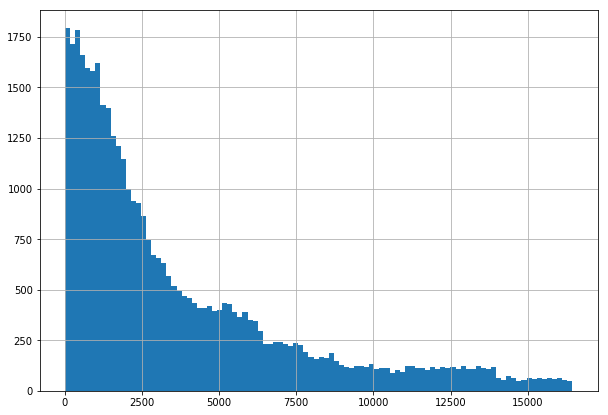

In [162]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

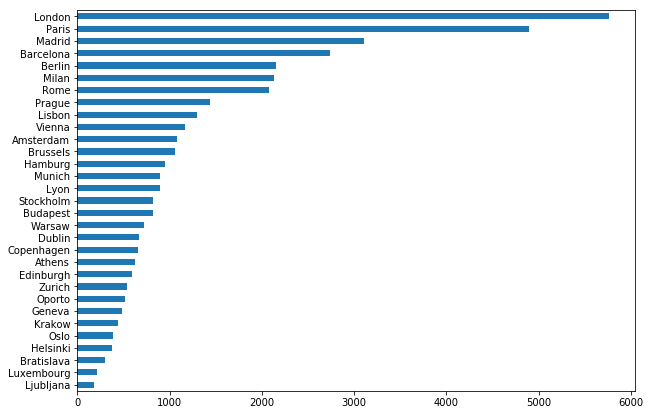

In [163]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

Понятно, что рэнкинг будет зависеть от количества ресторанов в городе

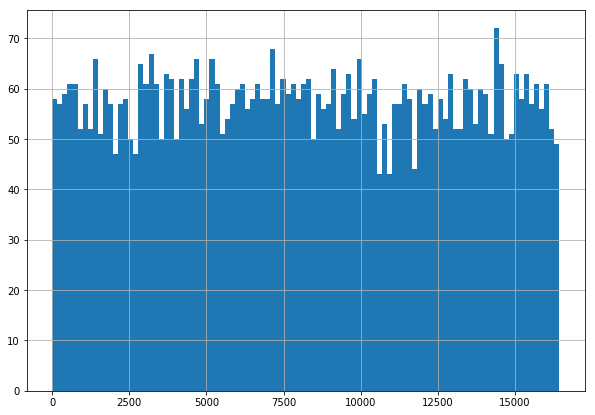

In [164]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

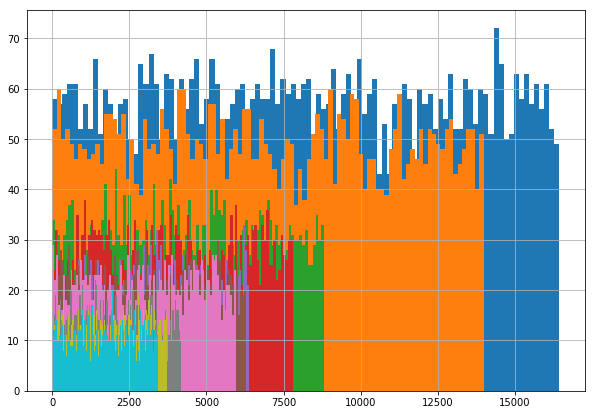

In [165]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

Чтобы избавиться от смещение Рэнкинг надо отнормировать, для этого сгенерированы нормированные признак 'rank_norm' и 'rank_norm_mm', который по итогу и оказывают наибольшее влияние на модель


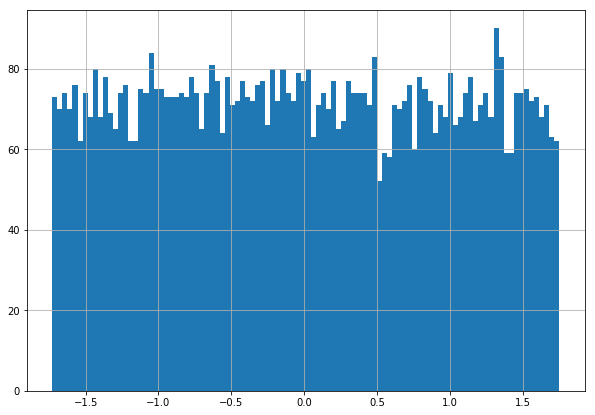

In [166]:
data['rank_norm'][data['City'] == 'London'].hist(bins=100)

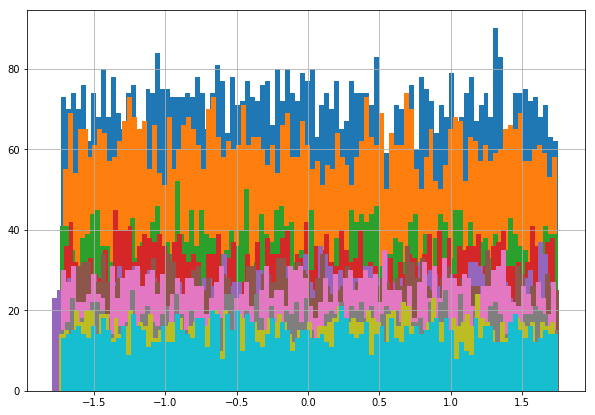

In [167]:
#посмотрим на топ 10 городов после нормировки
for x in (data['City'].value_counts())[0:10].index:
    data['rank_norm'][data['City'] == x].hist(bins=100)
plt.show()

### Посмотрим распределение целевой переменной

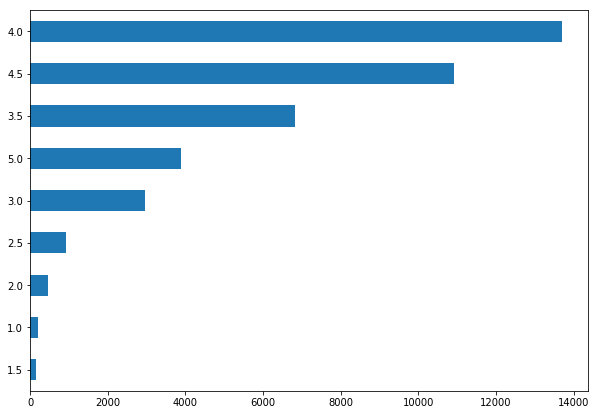

In [168]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

Преобладают рестораны с рейтингом 4.0 и 4.5. Целевая переменная имеет шаг 0.5, и это важно при формировании прогноза в модели.

### Посмотрим распределение целевой переменной относительно признака

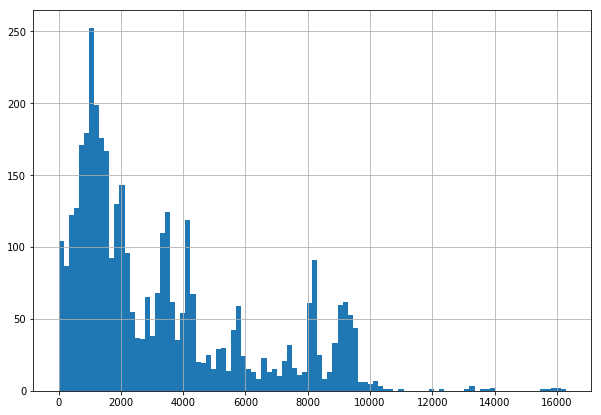

In [169]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

Рестораны с рейтингом 5.0 могут находится и на не самом популярном месте по Рэнкингу. 

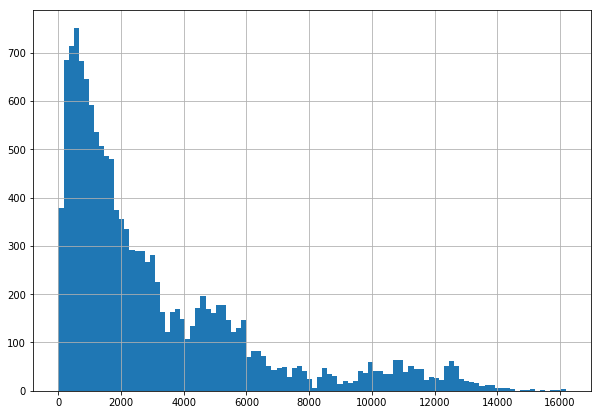

In [170]:
df_train['Ranking'][df_train['Rating'] == 4.0].hist(bins=100)

Четверка имеет меньше выбросов в "дальних краях" рэнкинга

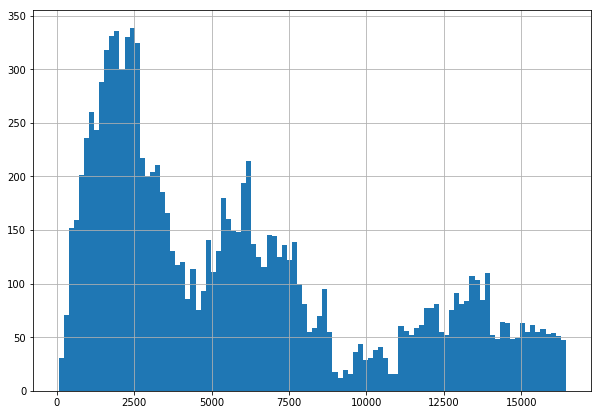

In [171]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

<Figure size 864x864 with 0 Axes>

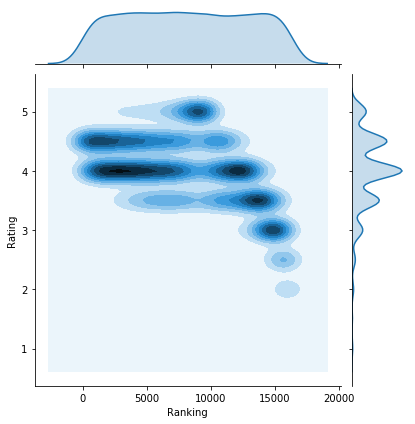

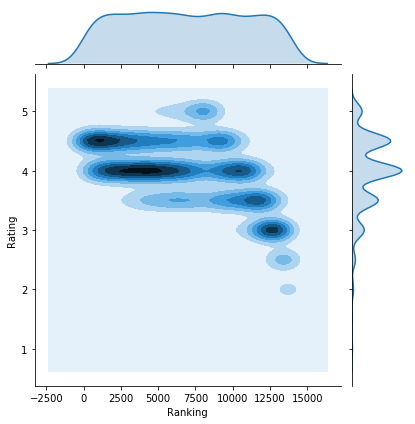

In [172]:
plt.figure(figsize=(12,12))
sns.jointplot(data=df_train[df_train.City == 'London'], x = 'Ranking', y='Rating', kind='kde')
sns.jointplot(data=df_train[df_train.City == 'Paris'], x = 'Ranking', y='Rating', kind='kde')

На графиках видно, что в вершине рэнкинга концентрируются рестораны с рейтингом 4.0 - 4.5

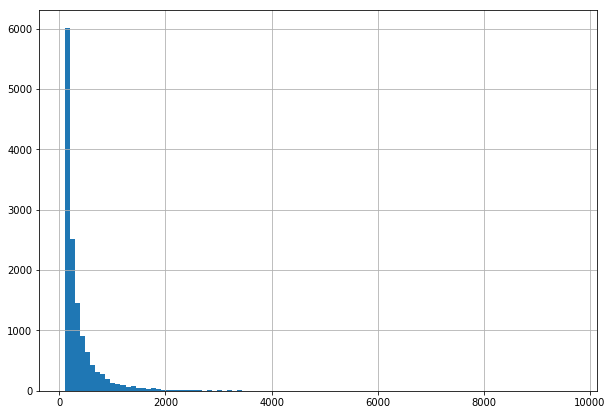

In [173]:
plt.rcParams['figure.figsize'] = (10,7)
data['Number of Reviews'][data['Number of Reviews']>100].hist(bins=100)

Большая часть ресторанов имеет количество отзывов меньше 10. Но и количество отзывов больше 5000, это не выбросы

In [174]:
l = data['Number of Reviews'].tolist()
sorted(l)[-40:]

[3603.0,
 3647.0,
 3795.0,
 3809.0,
 3837.0,
 3870.0,
 3962.0,
 4035.0,
 4080.0,
 4125.0,
 4234.0,
 4274.0,
 4373.0,
 4382.0,
 4382.0,
 4402.0,
 4437.0,
 4521.0,
 4567.0,
 4608.0,
 4694.0,
 4738.0,
 4904.0,
 4937.0,
 4977.0,
 4996.0,
 5011.0,
 5037.0,
 5216.0,
 5870.0,
 5927.0,
 6013.0,
 6309.0,
 6360.0,
 6437.0,
 6777.0,
 7575.0,
 7622.0,
 8927.0,
 9660.0]

In [175]:
data[data['Number of Reviews']>3500]

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Oceania,Kosher,Halal,Seafood,International,Street Food,Bar,Caribbean,Vegetarian Friendly,Scandinavian
44,id_44,Edinburgh,"[Seafood, European, British, Soups, North Euro...",266.0,$$$$,4567.0,"[['Come for the wine more than the food', 'Des...",/Restaurant_Review-g186525-d720945-Reviews-The...,d720945,0,...,0,0,0,1,0,0,0,0,1,0
216,id_216,Barcelona,"[Seafood, Mediterranean, European, Spanish, So...",981.0,$$ - $$$,4996.0,"[['Great place, locals go here to eat...', 'Ni...",/Restaurant_Review-g187497-d717275-Reviews-La_...,d717275,0,...,0,0,0,1,0,0,0,0,1,0
1158,id_1158,Prague,"[American, Bar, European, Mexican, Vegetarian ...",183.0,$$ - $$$,4382.0,"[['NYE', 'Good food, not as expensive as menti...",/Restaurant_Review-g274707-d1516182-Reviews-Ha...,d1516182,0,...,0,0,0,0,0,0,1,0,1,0
1369,id_1369,Rome,"[Pizza, Italian, Vegetarian Friendly, Vegan Op...",95.0,$$ - $$$,5037.0,[['Best dinner we had in Italy and in our ent....,/Restaurant_Review-g187791-d3666269-Reviews-Da...,d3666269,0,...,0,0,0,0,0,0,0,0,1,0
2550,id_2550,London,"[British, French, European, Vegetarian Friendl...",274.0,$$$$,5011.0,"[['Lovely chilled lunch', 'Birthday Lunch'], [...",/Restaurant_Review-g186338-d776287-Reviews-The...,d776287,0,...,0,0,0,0,0,0,0,0,1,0
4166,id_4166,Krakow,"[Eastern European, European, Eastern European,...",106.0,$$ - $$$,4608.0,"[['Traditional fayre - huge portions, good at....",/Restaurant_Review-g274772-d1009022-Reviews-Po...,d1009022,0,...,0,0,0,0,0,0,0,0,0,0
4952,id_4952,Budapest,"[European, Central European, Eastern European,...",40.0,$$ - $$$,4977.0,"[['Brilliant lunch', 'Worth to visit for local...",/Restaurant_Review-g274887-d4041036-Reviews-Ze...,d4041036,0,...,0,0,0,0,0,0,0,0,1,0
5295,id_5295,Brussels,"[French, Central European, Seafood, European]",189.0,$$ - $$$,6437.0,"[['Interesting restaurant, not sure of the fu....",/Restaurant_Review-g188644-d694788-Reviews-Che...,d694788,0,...,0,0,0,1,0,0,0,0,0,0
6254,id_6254,London,"[European, British]",311.0,$$$$,3647.0,"[['Extremely professional, yet casual service....",/Restaurant_Review-g186338-d700845-Reviews-Rul...,d700845,0,...,0,0,0,0,0,0,0,0,0,0
6275,id_6275,Madrid,"[Mediterranean, Spanish, Vegetarian Friendly, ...",23.0,$$ - $$$,3538.0,"[['Great Tapas', 'A wonderful old bar with fab...",/Restaurant_Review-g187514-d2527526-Reviews-Ta...,d2527526,0,...,0,0,0,0,0,0,0,0,1,0


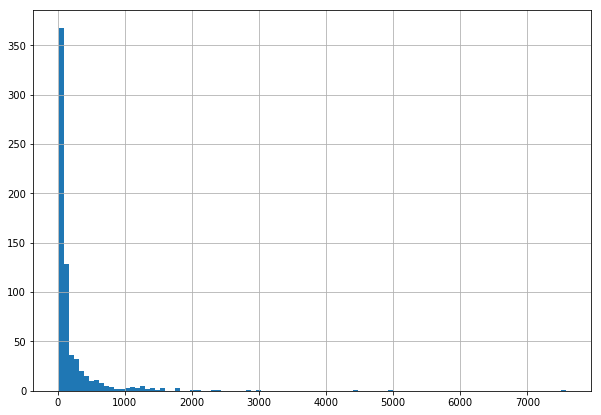

In [176]:
data['Number of Reviews'][(data['City'] == 'Budapest') & (data['Number of Reviews'] > 10)].hist(bins=100)

И от города к городу картина особо не меняется.

### Корреляция признаков

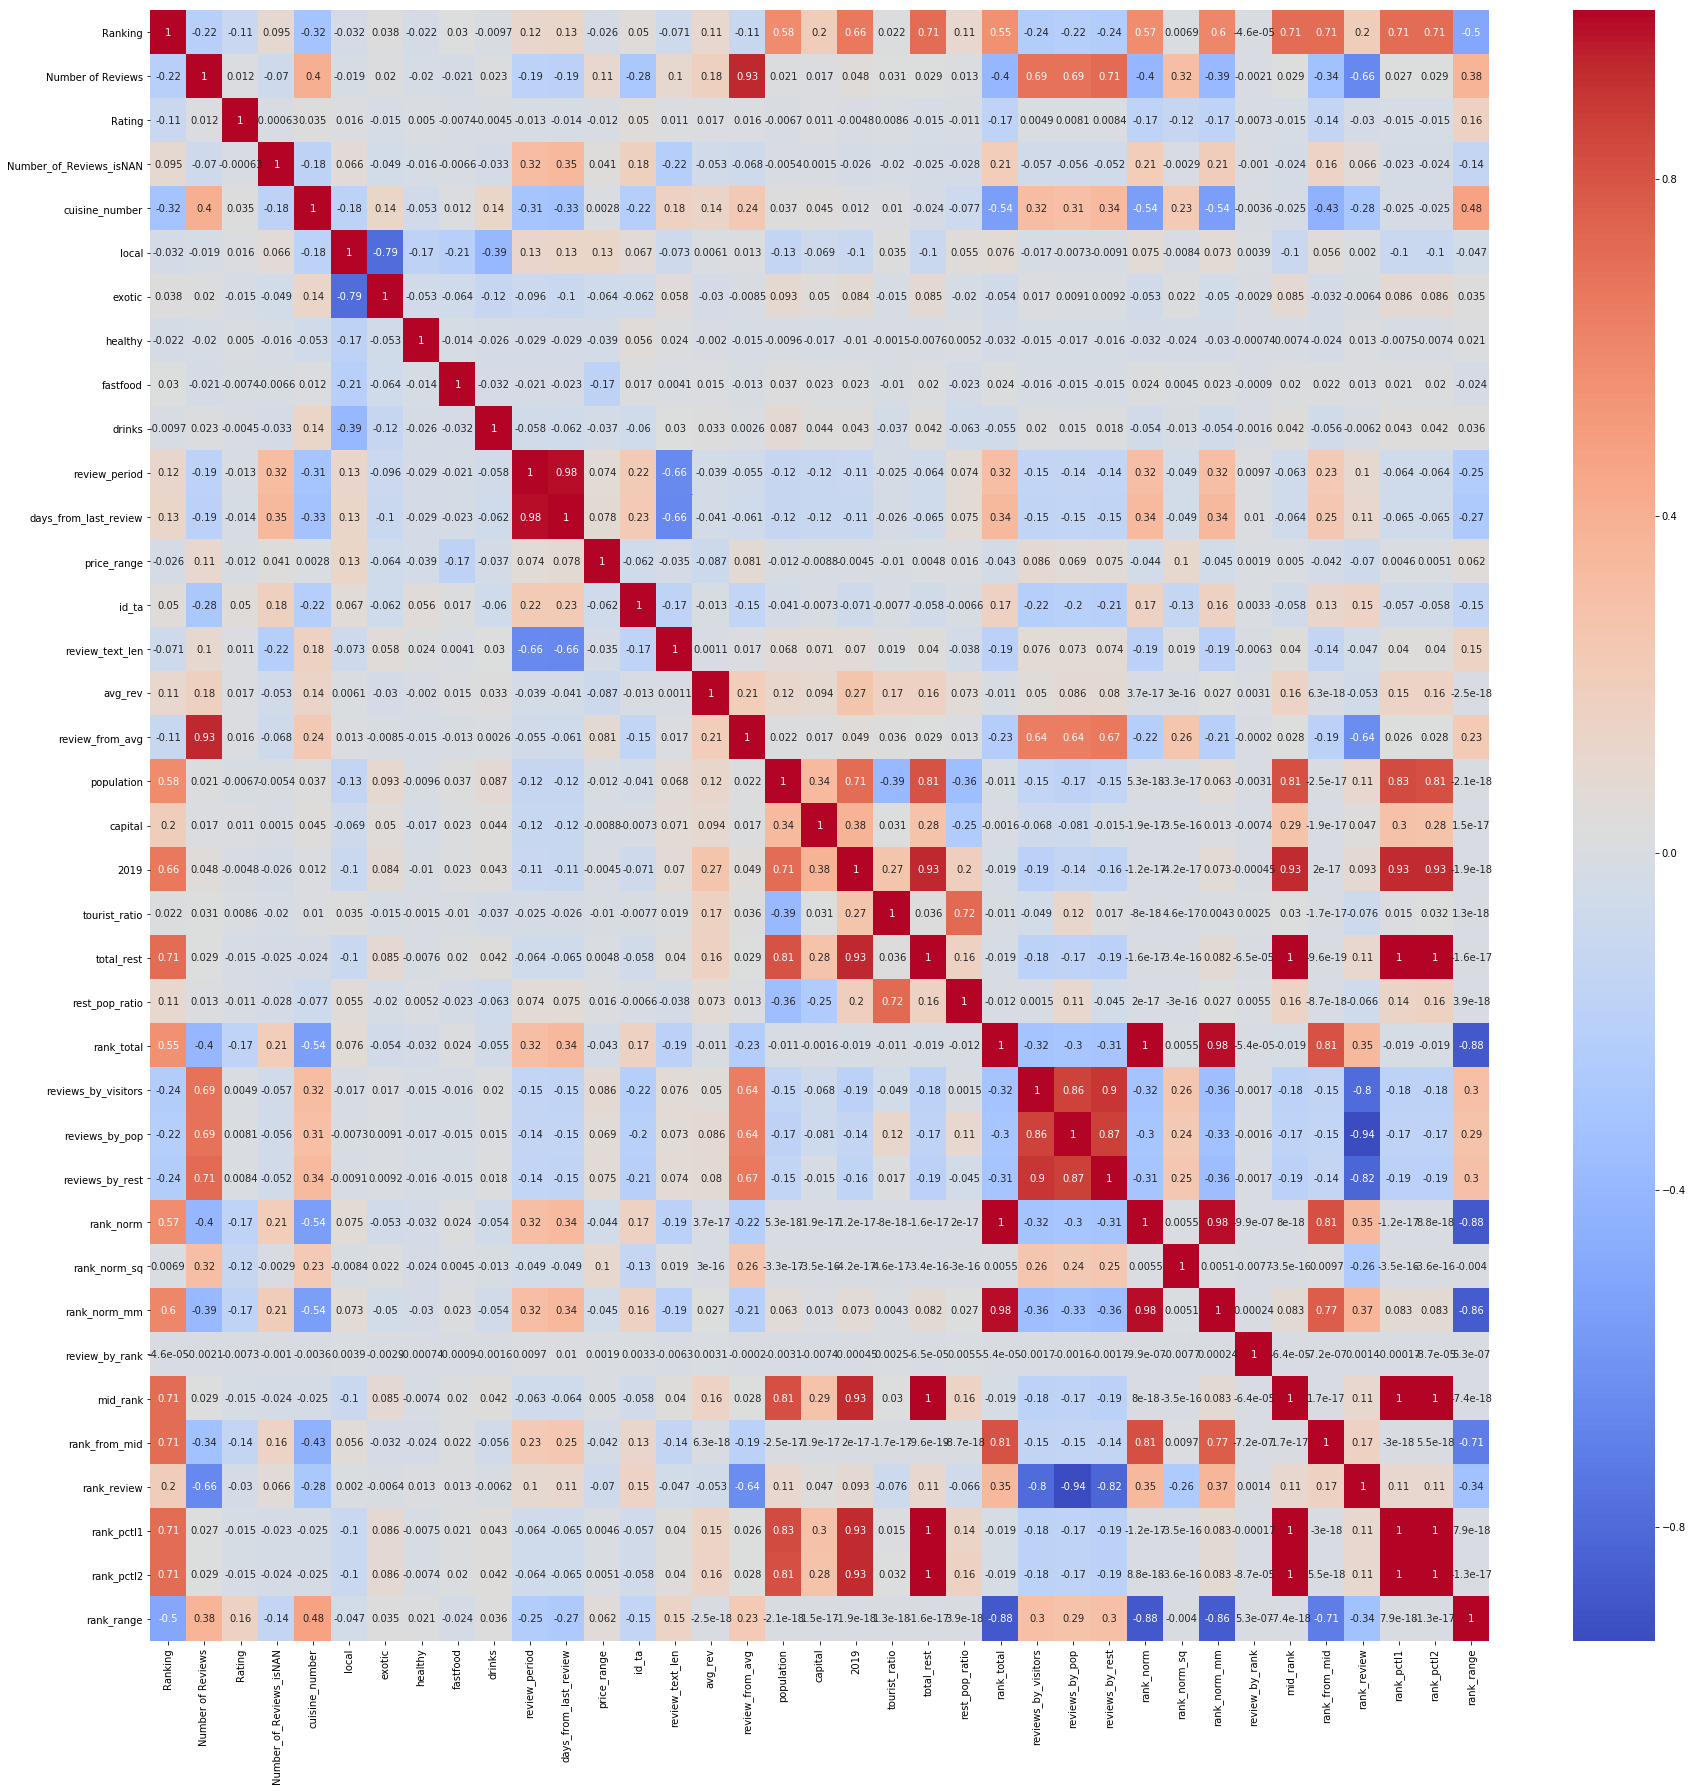

In [177]:
plt.rcParams['figure.figsize'] = (30,30)
sns.heatmap(data_for_corr.drop(['sample'], axis=1).corr(), annot=True, cmap='coolwarm')

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [178]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
pop = pd.read_csv('/kaggle/input/european-city-population/population.csv')
visitors = pd.read_csv('/kaggle/input/european-tourists/tourists.csv', delimiter = ';')

df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [179]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id'], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    
    df_output['Number_of_Reviews_isNAN'] = pd.isna(df_output['Number of Reviews']).astype('uint8')
    df_output['Cuisine Style'] = df_output['Cuisine Style'].fillna('European')
    df_output['Reviews'] = df_output['Reviews'].fillna('')
    
    # ################### 3. Encoding ############################################################## 
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: clear_text_list(x))
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: cuisine_correct(x))
    df_output['review_dates'] = df_output['Reviews'].apply(lambda x: re.findall(r'\d\d\/\d\d\/\d{4}',x))
    df_output['review_date1'] = df_output['review_dates'].apply(lambda x: None if len(x)==0
                                                                else x[0])
    df_output['review_date2'] = df_output['review_dates'].apply(lambda x: None if len(x)==0
                                                                else x[0] if len(x)==1
                                                                else x[1])
    df_output['review_date1'] = pd.to_datetime(df_output['review_date1'])
    df_output['review_date2'] = pd.to_datetime(df_output['review_date2'])
    df_output['review_date1'].fillna(datetime(2000,1,1,), inplace=True)
    df_output['review_date2'].fillna(datetime(1990,1,1,), inplace=True)
    df_output['price_range'] = df_output['Price Range'].apply(lambda x: None if pd.isnull(x)
                                                              else 1 if x == '$'
                                                              else 2 if x == '$$ - $$$'
                                                              else 3 if x == '$$$$'
                                                              else None)
    df_output['price_range'].fillna(df_output['price_range'].mode()[0],inplace=True)
    df_output['id_ta'] = df_output['ID_TA'].apply(lambda x: int(x.strip('d')))
    
    df_output['review_text'] = df_output['Reviews'].apply(lambda x: re.split(r'\d\d\/\d\d\/\d{4}',x, maxsplit=1))
    df_output['review_text'] = df_output['review_text'].apply(lambda x: x[0])
    df_output['review_text'] = df_output['review_text'].apply(lambda x: x.strip("'[], "))
    df_output['review_text'] = df_output['review_text'].apply(lambda x: clear_text_list(x))
    df_output['review_text_len'] = df_output['review_text'].apply(lambda x: len_mean(x))
    df_output.loc[df_output.review_text_len == 0, 'Number of Reviews'] = df_output.loc[df_output.review_text_len == 0,
                                                                                       'Number of Reviews'].fillna(0)
    
    avg_rev = pd.DataFrame(df_output.groupby(by='City').mean()['Number of Reviews']).reset_index()
    avg_rev.columns = ['City', 'avg_rev']
    df_output = df_output.merge(avg_rev, on = 'City', how='left')
    df_output['Number of Reviews'].fillna(df_output['avg_rev'], inplace=True)
    
    # ################### 3.5 Outer Data ############################################################## 
    
    df_output.loc[df_output.City == 'Oporto', 'City'] = "Porto"

    pop.drop('country', axis=1, inplace=True)
    pop.loc[pop.name == "Geneve", 'name'] = "Geneva"
    pop.loc[500] = {'name': 'Luxembourg', 'pop': 570000}
    pop.columns = ['City', 'population']
    
    df_output = df_output.merge(pop, on='City', how='left')


    A = {'City': ['Paris', 'Stockholm', 'London', 'Berlin', 'Munich', 'Porto', 'Milan', 'Bratislava', 'Vienna', 'Rome',
                  'Barcelona', 'Madrid', 'Dublin', 'Brussels', 'Zurich', 'Warsaw', 'Budapest', 'Copenhagen', 'Amsterdam',
                  'Lyon', 'Hamburg', 'Lisbon', 'Prague', 'Oslo', 'Helsinki', 'Edinburgh', 'Geneva', 'Ljubljana', 'Athens',
                  'Luxembourg', 'Krakow'],
         'capital': [1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0]
        }
    capitals = pd.DataFrame(A)
    df_output = df_output.merge(capitals, on='City', how='left')
    
    visitors.columns = ['rank', 'City', 'country', '2017', '2018', '2019']
    visitors['City']=visitors['City'].apply(lambda x: x.strip(' '))

    visitors.loc[100] = {'rank':100, 'City': 'Zurich', 'country':'Switzerland', '2017':0, '2018':0, '2019': 2240}
    visitors.loc[101] = {'rank':101, 'City': 'Hamburg', 'country':'Germany', '2017':0, '2018':0, '2019': 1450}
    visitors.loc[102] = {'rank':102, 'City': 'Bratislava', 'country':'Czech', '2017':0, '2018':0, '2019': None}
    visitors.loc[103] = {'rank':103, 'City': 'Lyon', 'country':'France', '2017':0, '2018':0, '2019': None}
    visitors.loc[104] = {'rank':104, 'City': 'Oslo', 'country':'Norway', '2017':0, '2018':0, '2019': None}
    visitors.loc[105] = {'rank':105, 'City': 'Helsinki', 'country':'Finland', '2017':0, '2018':0, '2019': None}
    visitors.loc[106] = {'rank':106, 'City': 'Edinburgh', 'country':'UK', '2017':0, '2018':0, '2019': 1660}
    visitors.loc[107] = {'rank':107, 'City': 'Geneva', 'country':'UK', '2017':0, '2018':0, '2019': 1150}
    visitors.loc[108] = {'rank':108, 'City': 'Ljubljana', 'country':'UK', '2017':0, '2018':0, '2019': None}
    visitors.loc[109] = {'rank':109, 'City': 'Luxembourg', 'country':'UK', '2017':0, '2018':0, '2019': None}

    visitors['2019'] = visitors['2019'].apply(lambda x: None if x == None
                                              else float(x))
    visitors['2019'].fillna(visitors['2019'].min(), inplace=True)

    df_output = df_output.merge(visitors[['City', '2019']], on='City', how='left')
    
    
       
    # ################### 4. Feature Engineering ####################################################
    
    df_output['cuisine_number'] = df_output['Cuisine Style'].apply(lambda x: len(x))
    df_output['local'] = df_output['Cuisine Style'].apply(local_cuisine)
    df_output['exotic'] = df_output['Cuisine Style'].apply(exotic_cuisine)
    df_output['healthy'] = df_output['Cuisine Style'].apply(healthy_cuisine)
    df_output['fastfood'] = df_output['Cuisine Style'].apply(fastfood_cuisine)
    df_output['drinks'] = df_output['Cuisine Style'].apply(drinks_cuisine)
    df_output['review_period'] = (df_output['review_date1'] - df_output['review_date2'])
    df_output['review_period'] = df_output['review_period'].apply(lambda x: x.days)
    df_output['review_date_last'] = df_output[['review_date1','review_date2']].max(axis=1)
    df_output['days_from_last_review'] = datetime(2018,1,1) - df_output['review_date_last']
    df_output['days_from_last_review'] = df_output['days_from_last_review'].apply(lambda x: x.days)
    df_output['review_text_len'] = df_output['review_text'].apply(lambda x: len_mean(x))
    df_output['tourist_ratio'] = df_output['2019'] /df_output['population']*1000  
    total_rest = pd.DataFrame(df_output.groupby(by='City').count()['Ranking']).reset_index()
    total_rest.columns = ['City', 'total_rest']
    df_output = df_output.merge(total_rest, on='City', how='left')
    df_output['rest_pop_ratio'] = df_output['total_rest'] / df_output['population'] * 1000
    df_output['rank_total'] = df_output['Ranking'] / df_output['total_rest']
    #df_output['reviews_by_visitors'] = df_output['Number of Reviews'] / df_output['2019'] * 1000 - ухудшает МАЕ
    #df_output['reviews_by_pop'] = df_output['Number of Reviews'] / df_output['population'] * 1000 - ухудшает МАЕ
    df_output['reviews_by_rest'] = df_output['Number of Reviews'] / df_output['total_rest'] * 1000
    
    
    rank_stat_DF = pd.DataFrame(columns = ['City', 'rank_mean', 'rank_STD' ])
    for city in df_output['City'].unique():
        rank_mean = df_output['Ranking'][df_output['City']==city].mean()
        rank_STD = np.std(df_output[df_output['City']==city]['Ranking'])
        rank_stat_DF = rank_stat_DF.append({'City':city, 'rank_mean': rank_mean, 'rank_STD': rank_STD},
                                           ignore_index=True)
    df_output = df_output.merge(rank_stat_DF, on='City', how='left')
    df_output['rank_norm'] = (df_output['Ranking']- df_output['rank_mean']) / df_output['rank_STD']
    df_output.drop(['rank_mean', 'rank_STD'], axis=1, inplace=True)
    df_output['rank_norm_sq'] = df_output['rank_norm'] ** 2
    
    #rank_minmax_DF = pd.DataFrame(columns = ['City', 'rank_min', 'rank_max' ])
    #for city in df_output['City'].unique():
    #    rank_min = df_output['Ranking'][df_output['City']==city].min()
    #    rank_max = df_output['Ranking'][df_output['City']==city].max()
    #    rank_minmax_DF = rank_minmax_DF.append({'City':city, 'rank_min': rank_mean, 'rank_max': rank_max},
    #                                           ignore_index=True)
    #df_output = df_output.merge(rank_minmax_DF, on='City', how='left')
    #df_output['rank_norm_mm'] = (df_output['Ranking']- df_output['rank_min']) / (df_output['rank_max'] - df_output['rank_min'])
    #df_output.drop(['rank_min', 'rank_max'], axis=1, inplace=True)
    
    mid_rank = pd.DataFrame(df_output.groupby(by='City').mean()['Ranking']).reset_index()
    mid_rank.columns = ['City', 'mid_rank']
    df_output = df_output.merge(mid_rank, on='City', how='left')
    df_output['rank_from_mid'] = df_output['Ranking'] - df_output['mid_rank']
    
    rank_pctl_DF = pd.DataFrame(columns = ['City', 'rank_pctl1', 'rank_pctl2'])
    for city in df_output['City'].unique():
        rank_pctl_DF = rank_pctl_DF.append({
            'City':city, 'rank_pctl1': np.percentile(df_output[df_output['City']==city].Ranking, [25, 75])[0],
            'rank_pctl2': np.percentile(df_output[df_output['City']==city].Ranking, [25, 75])[1]}, ignore_index=True)
    df_output = df_output.merge(rank_pctl_DF, on='City', how='left')
    conditions = [df_output['Ranking'] >= df_output['rank_pctl2'],
                  df_output['Ranking'] <= df_output['rank_pctl1'],
                  (df_output['Ranking'] < df_output['rank_pctl2']) & (df_output['Ranking'] > df_output['rank_pctl1'])]
    choices = [1, 3, 2]
    # df_output['rank_range'] = np.select(conditions, choices, default=np.nan) - ухудшает МАЕ
    
    # df_output['review_from_avg'] = abs(df_output['Number of Reviews'] - df_output['avg_rev']) - ухудшает МАЕ
    df_output['review_by_rank'] = df_output['Number of Reviews'] / df_output['rank_norm_sq']
    # df_output['rank_review'] =  df_output['rank_norm']  *  df_output['reviews_by_pop'] - ухудшает МАЕ
    
    # ################### 4.5 Dummy Features ####################################################
    
    
    df_output = df_output.join(pd.get_dummies(data['City']))
    
    cuisines = set()
    for item in df_output['Cuisine Style']:
        for element in item:
            cuisines.add(element)
    cuisines = list(cuisines)
    
    for cuisin in cuisines:
        df_output[cuisin] = df_output['Cuisine Style'].apply(lambda x: find_cuisin(x, cuisin))
        
    #df_output = pd.get_dummies(df_output, columns=['rank_range'], dummy_na=True)
            
    # ################### PolynomialFeatures Test ####################################################
    #pf = PolynomialFeatures(degree=3, interaction_only=False)
    #poly_features = pf.fit_transform(df_output[['rank_norm','Number of Reviews', 'days_from_last_review']]) 
    #a = pd.DataFrame(poly_features)
    #a.columns = pf.get_feature_names()
    #a.drop('1', axis=1, inplace = True)
    #df_output=df_output.join(a)
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберем их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    object_columns1 = [s for s in df_output.columns if df_output[s].dtypes == 'datetime64[ns]']
    df_output.drop(object_columns, axis = 1, inplace=True)
    df_output.drop(object_columns1, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [180]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Number of Reviews,sample,Rating,Number_of_Reviews_isNAN,price_range,id_ta,review_text_len,avg_rev,population,...,Oceania,Kosher,Halal,Seafood,International,Street Food,Bar,Caribbean,Vegetarian Friendly,Scandinavian
15842,2579.0,22.0,1,4.5,0,2.0,8001266,21.5,128.497008,1621537,...,0,0,0,0,0,0,0,0,0,0
2955,148.0,373.0,0,0.0,0,3.0,896610,28.5,88.543901,1019022,...,0,0,0,0,0,0,0,0,1,0
1548,891.0,267.0,0,0.0,0,2.0,4419361,21.0,128.497008,1621537,...,0,0,0,0,0,0,0,0,1,0
49639,13402.0,27.0,1,2.5,0,3.0,1109781,0.0,112.719702,2138551,...,0,0,0,0,0,0,0,0,0,0
37984,1576.0,37.0,1,4.0,0,1.0,4959546,37.5,59.354016,3426354,...,0,0,0,0,0,0,0,0,1,0
42727,5112.0,297.0,1,3.0,0,1.0,1943672,24.0,160.651769,1236837,...,0,0,0,1,0,0,0,0,0,0
35137,1531.0,3.0,1,4.5,0,2.0,13109977,0.0,83.810883,472317,...,0,0,0,0,0,0,0,0,0,0
20442,1208.0,19.0,1,4.5,0,2.0,8425520,14.5,114.738806,1165581,...,0,0,0,0,0,0,0,0,0,0
42192,4131.0,44.0,1,1.5,0,2.0,4733480,33.0,114.738806,1165581,...,0,0,0,0,0,0,0,0,0,0
49677,395.0,42.0,1,4.5,0,2.0,9819253,29.5,73.297153,1260391,...,0,0,0,0,1,0,0,0,0,0


In [181]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 108 entries, Ranking to Scandinavian
dtypes: float64(18), int64(58), uint8(32)
memory usage: 32.1 MB


In [183]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [184]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [185]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 107), (40000, 107), (40000, 106), (32000, 106), (8000, 106))

# Model 
Сам ML

In [186]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [187]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [188]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [189]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.193874375


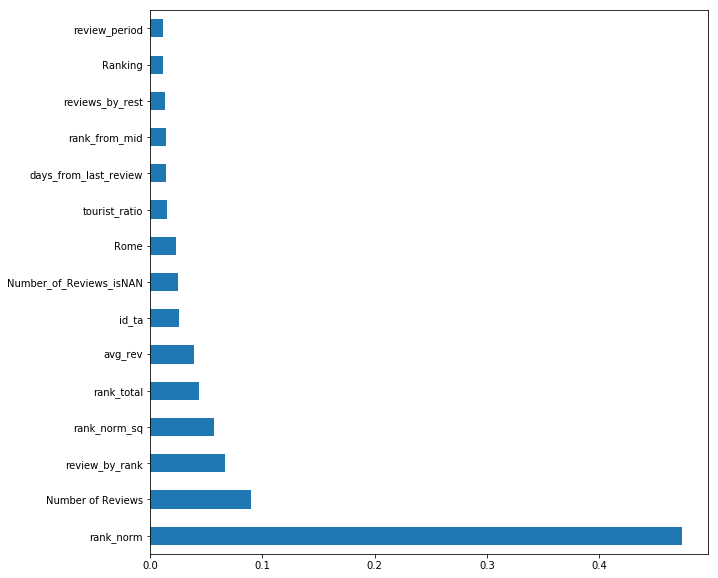

In [198]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission

In [191]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,Number_of_Reviews_isNAN,price_range,id_ta,review_text_len,avg_rev,population,capital,...,Oceania,Kosher,Halal,Seafood,International,Street Food,Bar,Caribbean,Vegetarian Friendly,Scandinavian
365,8909.0,136.936501,0.0,1,2.0,7297021,21.0,136.936501,7556900,1,...,0,0,0,0,0,0,0,0,0,0
7121,4381.0,74.000000,0.0,0,2.0,4910063,9.5,136.936501,7556900,1,...,0,0,1,0,0,0,0,0,1,0
7785,2547.0,2.000000,0.0,0,2.0,8639369,0.0,88.543901,1019022,1,...,0,0,0,0,0,0,1,0,0,0
2789,10769.0,0.000000,0.0,1,2.0,9806573,0.0,112.719702,2138551,1,...,0,0,0,0,0,0,0,0,0,0
9946,713.0,9.000000,0.0,0,3.0,12448464,20.0,92.087500,1153615,1,...,0,0,0,0,0,0,0,0,0,1
9914,2915.0,3.000000,0.0,0,2.0,1319237,22.0,88.543901,1019022,1,...,0,0,0,0,0,0,0,0,0,0
7581,10388.0,9.000000,0.0,0,2.0,4809044,32.0,112.719702,2138551,1,...,0,0,0,0,0,0,0,0,0,0
8041,14706.0,136.936501,0.0,1,2.0,2459488,45.0,136.936501,7556900,1,...,0,0,0,0,0,0,0,0,0,0
4814,7898.0,16.000000,0.0,0,2.0,3377744,19.5,112.719702,2138551,1,...,0,0,0,0,0,0,0,0,0,0
6730,629.0,220.000000,0.0,0,2.0,2689394,44.0,160.651769,1236837,0,...,0,0,0,0,0,0,0,0,0,0


In [192]:
test_data = test_data.drop(['Rating'], axis=1)

In [193]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [194]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [195]:
predict_submission

array([3.075, 4.17 , 4.53 , ..., 3.015, 4.445, 4.255])

In [196]:
sample_submission['Rating'] = predict_submission
sample_submission['Rating'] = sample_submission['Rating'].apply(lambda x: rating_round(x))
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.0
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5
